# Classifying Bangla Fake News with HuggingFace Transformers and Fastai


- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

![](https://github.com/Tahsin-Mayeesha/tahsin_mayeesha/raw/master/images/fakenews/front.jpg)

In this post we cover fine tuning a [multilingual BERT](https://huggingface.co/bert-base-multilingual-cased) model from Huggingface Transformers library on [**BanFakeNews**](https://aclanthology.org/2020.lrec-1.349/) dataset released in LREC 2020. While English Fake News Classification and fact checking tasks have many resources and competitions available such as [fake news challenge](http://www.fakenewschallenge.org/) and [hateful meme detection](https://ai.facebook.com/blog/hateful-memes-challenge-and-data-set/), similar efforts in Bangla has been almost non existent. BanFakeNews dataset contains 50k annotated articles from different news sources in Bangladesh, out of them around 1200 articles have been annotated as fake. As transformer architectures uses self attention to learn contextual embeddings they have been very popular in NLP research community for a while and many tools have been built around them.

This post is reusing materials taught in Weights and Bias's study group of Fast ai with Huggingface([link](https://wandb.ai/wandb_fc/events/reports/W-B-Study-Group-Lectures-fast-ai-w-Hugging-Face--Vmlldzo4NDUzNDU?galleryTag=events)) where several recent(2021) libraries([blurr](https://github.com/ohmeow/blurr),[Fasthugs](https://github.com/morganmcg1/fasthugs) & [Adaptnlp](https://novetta.github.io/adaptnlp/)) that integrates components from popular deep learning frameworks Huggingface transformers and Fastai v2 are shown. 

My experience with using Transformers is fairly low, recently I participated in Huggingface's Flax/Jax week and there our team pretrained [Bengali GPT2](https://huggingface.co/flax-community/gpt2-bengali) and [T5](https://huggingface.co/flax-community/Bengali-t5/tree/main), so I was looking into Huggingface course and documentation to learn more about how to finetune transformers. Previously my thesis journal paper for undergraduate ["Deep Learning based Question Answering System in Bengali"](https://www.tandfonline.com/doi/full/10.1080/24751839.2020.1833136) worked on Bangla Question Answering with transformers, but I had stuck more to given scripts back then and focused more on synthetic dataset construction via translation and handling data corruption issues. So this post will focus more on the high level API of ```Blurr``` and the components of huggingface and fastai that are relevant for getting started quickly. 

In [1]:
!pip install -Uqq transformers datasets tqdm
!pip install -Uqq ohmeow-blurr
!pip install -Uqq wandb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import wandb

from transformers import *
from fastai.text.all import *
from fastai.callback.wandb import *


from blurr.data.all import *
from blurr.modeling.all import *

We will use weights and biases for tracking experiments and runs. Project page : https://wandb.ai/tasmiah-tahsin/fake-news-blurr

In [6]:
wandb.login()

wandb: Currently logged in as: tasmiah-tahsin (use `wandb login --relogin` to force relogin)


True

# Load dataset

This dataset has been downloaded from [Kaggle](https://www.kaggle.com/cryptexcode/banfakenews). Note that there are four files in the given dataset, but we use the two files (Authentic-48k and fake-1k) here because the rest of the files contain labelled fake and authentic news. Labelling in the sense of what type of fake news it is, clickbait, satire, misleading or false context, for the current priliminary phase we stick to binary classification of knowing if a news is fake or authentic. We also concatanate headline and content of the news article during preprocessing and combine the fake and authentic news dataset before sending them to Blurr dataloaders. This dataset is heavily imbalanced, so I'll take approximately half of the authentic news set, since taking full set takes each epoch with a batch size of four around an hour.



![](https://github.com/Tahsin-Mayeesha/tahsin_mayeesha/raw/master/images/fakenews/dataset_preview.png)

In [7]:
fake = pd.read_csv("/content/drive/MyDrive/fake news/Fake-1K.csv")
authentic = pd.read_csv("/content/drive/MyDrive/fake news/Authentic-48K.csv",engine='python',error_bad_lines=False,warn_bad_lines=True,nrows=15000)
df = pd.concat([authentic[['headline','content','label']],fake[['headline','content','label']]])
df.reset_index(drop=True,inplace=True)

In [8]:
print(authentic.shape, fake.shape)

(15000, 7) (1299, 7)


In [9]:
df['text'] = df['headline'] + df['content']

In [10]:
df = df.drop(['headline','content'],axis=1)

In [11]:
df.head(1)

,label,text
0,1,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজগত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে (বাকৃবি) উপাচার্যের কার্যালয়ে হট্টগোলের ঘটনায় দুইজনকে সাময়িক বরখাস্ত ও ছয় জনকে শোকজ করেছে বিশ্ববিদ্যালয় প্রশাসন। বুধবার বিশ্ববিদ্যালয় বাকৃবি রেজিস্ট্রার সাইফুল ইসলাম স্বাক্ষরিত এক নোটিশে আগামী ৭ দিনের মধ্যে উপযুক্ত উত্তর দেয়ার নির্দেশ দেয়া হয়েছে। এদিকে এ ঘটনায় আন্দোলনের সঙ্গে একাত্বতা প্রকাশ না করায় হামলার শিকার হয়ে কারিগরি কর্মচারী পরিষদের সভাপতি ও সাধারণ সম্পাদক হাসপাতালে ভর্তি হয়েছেন। সাময়িক বরখাস্তরা হলেন- শিক্ষা বিষয়ক শাখার কর্মচারী ও ৩য় শ্রেণির সাধারণ সম্পাদক মো. মোশারফ হোসেন ও কর্মকর্তা পরি..."


In [12]:
df.label=df.label.map({1:"Authentic",0:"Fake"})

In [13]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df, test_size=0.2)

We will use ```Blurr``` high level API for sequence classification with the pandas dataframe where ```BlearnerForSequenceClassification.from_dataframe()``` method takes in a dataframe, splits them from the column of default ```is_valid``` using Fastai's [```ColSplitter```](https://docs.fast.ai/data.transforms.html#ColSplitter) into train and test splits, constructs the datablock and dataloaders and uses them for training. So we add a ```'is_valid'``` column in the dataframe. There are other ways of splitting the data available in Fastai like ```RandomSubsetSplitter``` where we can randomize the data inside a dataframe. Since we used scikit-learns train test split to shuffle the dataframe for now we can go with Column based splitting. 

In [ ]:
train['is_valid'] = False
valid['is_valid'] = True

In [15]:
final_df = pd.concat([train,valid],axis=0)

In [16]:
final_df.shape

(16299, 3)

In [17]:
final_df.head()

,label,text,is_valid
15212,Fake,"জীবনে কখনো প্রেমে বিচ্ছেদ ঘটেছে? দেখুনতো বিচ্ছেদের পর আপনিও ঠিক একই কাজগুলো করেছেন কিনা? - Bengal Beatsমানুষ প্রেমে পড়লে হালকা বদলে যায়, কথাটি যেমন সত্য। তেমনি প্রেমে বিচ্ছেদ ঘটলে পুরোপুরি উল্টো বনে যায়, সে কথাটি তার চেয়েও বেশি সত্য। কারণ বিচ্ছেদের পর অনেককেই দেখা যায় যে দুঃখ ভুলে থাকার জন্য হোক কিংবা ঢেকে রাখার জন্যে হলেও হোক, পুরোপুরি বিপরীত চরিত্রের কেউ বনে গিয়ে নানান রকম নতুন জিনিস নিয়ে ব্যস্ত থাকার চেষ্টা করি। মজার বিষয়টা হলো- চাইলেই কি আর আশেপাশের মানুষগুলোর চোখ ফাঁকি দিয়ে আবেগ লুকিয়ে রাখা যায়? নিশ্চই যায় না। কিন্তু তার পরও আমরা কিছু কাজ করি যা সবার মাঝে একদমই কমন। আসুন জেনে নেই প্রে...",False
13898,Authentic,"নির্বাচনে সেনা মোতায়েনের বিষয়ে যা বললেন সিইসি ২৫ সেপ্টেম্বর, ২০১৮ ২১:৪৪প্রধান নির্বাচন কমিশনার (সিইসি) কেএম নুরুল হুদা জানিয়েছেন, আগামী একাদশ জাতীয় সংসদ নির্বাচনে সেনাবাহিনী মোতায়েন করা হবে কিনা, সে বিষয়ে তফসিল ঘোষণার পর সিদ্ধান্ত নেয়া হবে। মঙ্গলবার (২৫ সেপ্টেম্বর) বিকালে একাদশ জাতীয় সংসদ নির্বাচন উপলক্ষে দিনাজপুরে জেলা প্রশাসন ও আইনশৃঙ্খলা বাহিনীর সঙ্গে মতবিনিময় সভা শেষে সাংবাদিকদের সঙ্গে আলাপকালে সিইসি এসব কথা বলেন। নির্বাচনে সেনা মোতায়েনের বিষয়ে সিইসি বলেন, এখনও সিদ্ধান্ত হয়নি। তফসিল ঘোষণার পর কমিশনের বৈঠক করব, সেনাবাহিনী ব্যবহারের প্রয়োজনীয়তা দেখা দিলে, কমিশনে এ বিষয়ে সিদ্ধান্ত নেব। স...",False
4834,Authentic,"হবিগঞ্জে পরিবারের ওপর হামলা ও লুটপাটের ঘটনায় মামলাজেলার নবীগঞ্জ উপজেলার দেবপাড়া ইউনিয়নের রস্তুমপুর গ্রামে একটি পরিবারের ওপর হামলা, ভাঙচুর ও লুটপাটের ঘটনায় অভিযোগে মামলা হয়েছে। গত ১৮সেপ্টেম্বর হামলার শিকার ওই গ্রামের আব্দুল কালাম বাদী হয়ে হবিগঞ্জ অতিরিক্ত চীফ জুডিসিয়াল ম্যাজিস্ট্রেট আদালতে ১২ জনকে আসামি করে মামলা দায়ের করেন। মামলাটি আমলে নিয়ে ৩ দিনের ভিতরে মামলার রুজু সংক্রান্ত বিষয়ে আদালতকে অবহিত করার জন্য নবীগঞ্জ থানার অফিসার ইনচার্জকে নির্দেশ দিয়েছেন আদালত। মামলার এজাহারে উল্লেখ করা হয়, ওই গ্রামের মধু মিয়া মেম্বার হত্যাকাণ্ডের ঘটনায় তাঁর পুত্র মামলা দায়ের করেন। ওই মামলার স্বাক্ষী মানা ...",False
8249,Authentic,"জাতির জনক ও রাষ্ট্রপতির নামই জানে না এই শিক্ষার্থীরাদফায় দফায় ভাঙনে অবকাঠামোর অবস্থা একেবারে নাজুক। তারমধ্যে শিক্ষকদের চরম অবহেলা। ফলে দুর্বল হয়ে পড়ছে চরাঞ্চলের খেটে-খাওয়া মানুষের সন্তানদের শিক্ষা জীবনের ভিত্তি। সুন্দরগঞ্জের উজান বুড়াইল সরকারি প্রাথমিক বিদ্যালয়। দুই শতাধিক শিক্ষার্থীর বিপরীতে শিক্ষক দুই জন। অবকাঠামো বলতে জরাজীর্ণ টিনশেড ঘর। গুটি কয়েক শিক্ষার্থীকে পাঠদান করেন সহকারী শিক্ষক। অপর শিক্ষক আসেন সপ্তাহে দুই থেকে তিনদিন। যেই শিক্ষক নিয়মিত ক্লাস করান তিনি বলেন, এখানে দুইজন শিক্ষক। আরেকজন সপ্তাহে দুই থেকে তিনদিন আসেন। পাশের চরের স্কুল বোচাগাড়ি ভুঁইয়া সরকারি প্রাথমিক বিদ্যালয়। চার ...",False
1327,Authentic,"সংসদে পাস ডিজিটাল নিরাপত্তা আইনে কী আছেনিউজ ডেস্ক আরটিএনএন ঢাকা: সাইবার তথা ডিজিটাল অপরাধের কবল থেকে রাষ্ট্র এবং জনগণের জান-মাল ও সম্পদের নিরাপত্তা বিধানে প্রয়োজনীয় বিধান করে আজ সংসদে ডিজিটাল নিরাপত্তা বিল, ২০১৮ সংশোধিত আকারে পাস করা হয়েছে। ডাক, টেলিযোগাযোগ ও তথ্যপ্রযুক্তি মন্ত্রী মোস্তাফা জব্বার বিলটি পাসের প্রস্তাব করেন। বিলে বিধান করা হয় যে, এর কোনো বিধানের সাথে অন্য কোনো আইনের কোনো বিধান অসামঞ্জস্য হয়, তাহলে অন্য কোনো আইনের বিধানের সাথে যতটুকু অসামঞ্জস্য হয় ততটুকুর ক্ষেত্রে প্রস্তাবিত বিলের বিধান কার্যকর হবে। বিলে বিধান করা হয় যে, কোনো ব্যক্তি দেশের বাইরে বিলের বিধানের অধীন কোনো অপরাধ ...",False


In [18]:
final_df.label.value_counts()

Authentic    15000
Fake          1299
Name: label, dtype: int64

# Model Training

## Multilingual BERT

Since the original paper also used [multilingual cased bert](https://github.com/google-research/bert/blob/master/multilingual.md) released by Google this post can be considered as an attempt to reproduce the work of BanFakeNews. They trained mbert for 50 epochs with a learning rate of 0.00002 and optimizer Adam. The batch size was 32. The overall F1 score after training for 50 epochs on this dataset was .99 and f1 for fake class was 0.68. Multilingual bert has been pretrained on 104 languages including bengali with wordpiece tokenization. As bengali is already included it makes it a valid choice for current bangla text classification task. Information for this model are : 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters.  As the size of the language corpora varied greatly for low resource languages exponential weighted smoothing was performed for weighting data during the pretraining stage, which results in undersampling high resource languages like english and oversampling low resource languages like Bengali. Mbert does not use any marker for input language to enable zero shot training.

In [19]:
wandb_init_kwargs = {
    'reinit': True, 
    'project': "fake-news-blurr", 
    'entity': "tasmiah-tahsin",
    'notes': 'Finetuning banfakenews with multilingual bert via Blurr', 
    'tags': ['mbert', 'fake-news-classification', 'blurr']
  }

In [20]:
wandb.init(**wandb_init_kwargs)

Since I'm fairly new in ```blurr``` I'm using the high level API, but the key ideas are following. ```blurr``` is integrating two frameworks. Here ```Fastai``` is providing the ```datablock```, ```learner```, ```learning rate finder``` functionalities with Leslie Smith's 1cycle policy components, while huggingface transformers is providing the ready to use transformer model configuration and architectures made publicly available from huggingface hub(in general terms, but huggingface also has its own datasets library which integrates well with blurr, and fastai also provides pretrained language models based on LSTM like [ULMFiT](https://docs.fast.ai/tutorial.text.html) and [MultiFiT](https://nlp.fast.ai/classification/2019/09/10/multifit.html). 

Fastai's datablock API works like a specification for quickly loading a data into a model. The blocks are specific steps which can be mixed/matched for training with its various transforms and splitting functions along with visualization capacities. Datablocks, Callbacks, and other fastai concepts are explained in the paper ["fastai: A Layered API for Deep Learning"](https://arxiv.org/abs/2002.04688). Under the hood ```blurr``` is providing wrappers for the huggingface transformers and for finetuning the parameters of the model with enabling discriminative learning rate like used in[ULMFiT](https://paperswithcode.com/method/ulmfit). Discriminative learning rate refers to using variable learning rates for different layers of a network while performing transfer learning.

The low level API for ```blurr``` works with datablocks and dataloaders  creating the mini batches which are combined with the huggingface model architecture, optimizer and loss function inside a ```learner```. Mid level API contains ```BLearner``` and the highest level API contains task specific learners like the current one I'm using which is ```BlearnerForSequenceClassification```. 




In [21]:
from blurr.modeling.core import BlearnerForSequenceClassification
pretrained_model_name = "bert-base-multilingual-cased"
learn = BlearnerForSequenceClassification.from_dataframe(final_df, pretrained_model_name, dl_kwargs={ 'bs': 4})

SuggestedLRs(minimum=0.0013182567432522773, steep=0.05754399299621582, valley=0.0004786300996784121, slide=0.009120108559727669)

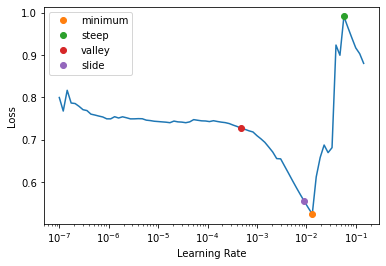

In [22]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])


I initially unfreezed all the layers and had set max learning rate to 1e-2 but the results were pretty bad. So I reduced the learning rate, decided to not do full unfreezing and retrained the model again. Original model in the training set was trained for 50 epochs, here we are experimenting with only 5 epochs though. Fastai documentation recommends that we set the learning rate equal to one order of magnitude lower than the minimum, so I went with 1e-3.

In [23]:
#learn.unfreeze()
learn.fit_one_cycle(5, lr_max=1e-3,cbs=[WandbCallback(log_preds=False, log_model=False)])

Could not gather input dimensions


epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.146906,0.196762,0.261168,0.934049,17:18
1,0.138746,0.092802,0.756757,0.966871,17:21
2,0.078837,0.095473,0.744731,0.966564,17:21
3,0.073069,0.085101,0.781818,0.970552,17:22
4,0.112354,0.092946,0.795506,0.972086,17:22


We can see some of the results by the model here. Our model trains on half of the dataset and achieves around 0.80 in overall f1. Its likely that the model is trained longer it will achieve better performance. I might retrain it later on full data.

In [24]:
learn.show_results(learner=learn, max_n=4,trunc_at=200)

,text,category,target
0,বদিবৃত্তান্ত : এক দশকে আবদুর রহমান বদির নানা ঘটনাবলিবেশ কয়েক বছর ধরেই বাংলাদেশে সবচেয়ে ভয়াল মাদকের নাম ইয়াবা ।'বাবা'নামে এটি সমাজের বিভিন্ন স্তরে বিশেষ করে তরুণদের মাঝে । সারা দেশে ইয়াবার মূল যোগ,Fake,Authentic
1,"বিএনপি শুদু লাঞ্ছনা বঞ্ছনা গঞ্জনা : শমশের | দৈনিক মতিকণ্ঠনিজস্ব মতিবেদকরাজনীতী হতে অবসর ঘোষনা বৃহত্তর ইসলামীর বিএনপি শাখার খারিজি, বৃহত্তর ইসলামীর বিএনপি শাখার মহিলা আমীর ও শক্তির মালিক আপোষহীন দেশনেত",Fake,Fake
2,"২১ আগস্ট মামলার বিএনপির শঙ্কা২১ আগস্ট গ্রেনেড হামলা আশঙ্কা প্রকাশ করে বিএনপি বলছে, সুপরিকল্পিতভাবে দেশকে ধ্বংস করার সকল সম্পন্ন করেছে সরকার । বন্দুকের নলের মুখে দেশ ত্যাগ ও পদত্যাগে বাধ্য প্রধান বিচার",Authentic,Authentic
3,নিউ পথে লন্ডনে প্রধানমন্ত্রীর যাত্রাবিরতিতাকে বহনকারী বিমান বাংলাদেশ ভিভিআইপি ফ্লাইটটি লন্ডনের শুক্রবার বিকাল ৩টা ৫০ মিনিটে হিথ্রো বিমানবন্দরে অবতরণ করে । যুক্তরাজ্যে বাংলাদেশের হাই কমিশনার নাজমুল কাও,Authentic,Authentic


In [25]:
wandb.finish()

epoch,5
train_loss,0.11235
raw_loss,0.77129
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▂▂▁▁▁▁▁▁▁▂▁
raw_loss,▄▁▄▁▅▃█▂▂▃▁▂▁▁▃▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▅▂
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁


![](../images/fakenews/wandb.png)

# Model Sharing

To upload our model to Huggingface hub we can use push_to_hub method available to the models. The details can be found [here](https://huggingface.co/transformers/model_sharing.html). We install git-lfs since the tokenizer and the model files are fairly large. After uploading the model to the huggingface hub we will also use ```pipeline``` functionality by transformers and combine with transformers interpret library to see how the model weights each of the input tokens when making predictions in the section below. 

In [26]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (1,521 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 160837 files and directories c

In [27]:
!transformers-cli login

2021-08-05 14:05:28.637619: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        
Username: Tahsin-Mayeesha
Password: 
Login successful
Your token: oSBeuCeqFwuZgHGyqIBjgHEmiAchBfqCTsadczfjKMwdGdOskZjIvLzkFxbQafNAbNHwgsNibftTGdtUfMvWLkBjGwsMGfpdekOyyFbWFVOOJUkktSsdoacPJeeuZkhi 

Your token has been saved to /root/.huggingface/token


In [28]:
!git config --global user.email "tasmiah.tahsin@northsouth.edu"

In [29]:
!git config --global user.name "Tahsin-Mayeesha"

In [30]:
blurr_tfm = get_blurr_tfm(learn.dls.before_batch)

In [31]:
blurr_tfm.hf_model.push_to_hub("bangla-fake-news-mbert",use_temp_dir=True)

'https://huggingface.co/Tahsin-Mayeesha/bangla-fake-news-mbert/commit/87af782acfa9632e8d06bb91cf3d234ff95d7613'

In [32]:
blurr_tfm.hf_tokenizer.push_to_hub("bangla-fake-news-mbert",use_temp_dir=True)

'https://huggingface.co/Tahsin-Mayeesha/bangla-fake-news-mbert/commit/b9a6a1c334d68ccec965cb44e5bf62bf38dedad3'

# Explaining predictions

Transformers interpret library tries to show weights for tokens after making predictions and make some visualizations. The tokens are split into subwords as per the tokenizer. 

In [50]:
!pip install transformers-interpret


     |████████████████████████████████| 1.4 MB 9.0 MB/s 
  Created wheel for transformers-interpret: filename=transformers_interpret-0.5.2-py3-none-any.whl size=23518 sha256=2c17eae901bad8c8340a6afc562d980d8caf5d83407c2ff3bc50c9704e62bccc
  Stored in directory: /root/.cache/pip/wheels/18/8a/5f/db643e1cd44e7bb22c21b52b8fcaebadafaf0b361c33f05869
Successfully built transformers-interpret


In [6]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_name = "Tahsin-Mayeesha/bangla-fake-news-mbert"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [28]:
text = "অভিনেতা আফজাল শরীফকে ২০ লাখ টাকার অনুদান অসুস্থ অভিনেতা আফজাল শরীফকে চিকিৎসার জন্য ২০ লাখ টাকা অনুদান দিয়েছেন প্রধানমন্ত্রী শেখ হাসিনা।"

In [29]:
# With both the model and tokenizer initialized we are now able to get explanations on an example text.
from transformers_interpret import SequenceClassificationExplainer
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)

In [30]:
word_attributions = cls_explainer(text)

In [25]:
word_attributions[0:10]

[('[CLS]', 0.0),
 ('[UNK]', 0.28880402350585194),
 ('ক', 0.25229517653263356),
 ('##র্ম', 0.22240842163848681),
 ('##ী', -0.011317794732531512),
 ('প', 0.17429296274096845),
 ('##া', -0.200330045967826),
 ('##ঠ', 0.09852698442198699),
 ('##ান', 0.08178611752043284),
 ('##োর', -0.21497962784889024)]

In [ ]:
cls_explainer.visualize()

![](https://github.com/Tahsin-Mayeesha/tahsin_mayeesha/raw/master/images/fakenews/visualize%20results.png)

# Resources

* fastai paper : https://arxiv.org/pdf/2002.04688.pdf
* https://github.com/ohmeow/blurr
* [fine-tuning mrpc with blurr colab](https://colab.research.google.com/gist/ohmeow/ee69e3c519bc68fbea5dd671afbdde39/fine-tuning-mrpc-with-blurr.ipynb#scrollTo=3Bih_uwhgMNS)
* weights and biases study group of fastai x huggingface [playlist](https://www.youtube.com/playlist?list=PLD80i8An1OEF8UOb9N9uSoidOGIMKW96t)
* [multilingual bert](https://huggingface.co/bert-base-multilingual-cased)
* https://github.com/cdpierse/transformers-interpret
* https://blog.dataiku.com/the-learning-rate-finder-technique-how-reliable-is-it